### Import Library

In [ ]:
# Install required packages
!pip install catboost
!pip install transformers
!pip install tensorflowjs
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load Dataset

In [ ]:
# Load Indonesian emotion dataset
url = 'https://raw.githubusercontent.com/go0se05/capstone-project/refs/heads/main/Dataset/emotion_ind.csv'
df = pd.read_csv(url)

In [ ]:
# 1. Drop kolom 'label' lama
df = df.drop(columns=['label'])

# 2. Encode ulang kolom 'emosi'
le = LabelEncoder()
df['label'] = le.fit_transform(df['emosi'])

# Cek mapping label
print("Mapping label:", dict(zip(le.classes_, le.transform(le.classes_))))

Mapping label: {'Cinta': np.int64(0), 'amarah': np.int64(1), 'kesedihan': np.int64(2), 'sukacita': np.int64(3), 'takut': np.int64(4)}


In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19948 entries, 0 to 19947
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    19948 non-null  object
 1   emosi   19948 non-null  object
 2   label   19948 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 467.7+ KB


,teks,emosi,label
0,Saya tidak merasa dipermalukan,kesedihan,2
1,Saya bisa beralih dari perasaan begitu putus a...,kesedihan,2
2,Saya meraih satu menit untuk memposting saya m...,amarah,1
3,Saya pernah merasa nostalgia tentang perapian ...,Cinta,0
4,Saya merasa Grouchy,amarah,1


### EDA

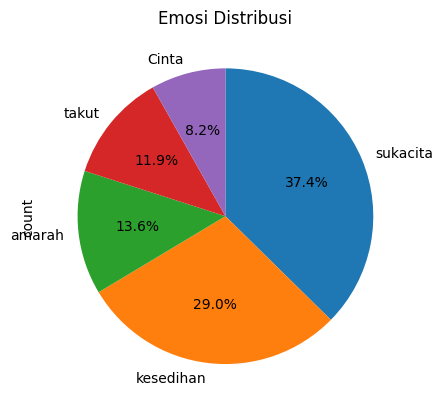

In [ ]:
# Visualization helps.
import matplotlib.pyplot as plt
import seaborn as sns
df['emosi'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, counterclock=False)

# Set title
plt.title('Emosi Distribusi')

# Display the plot
plt.show()

emosi
sukacita     7453
kesedihan    5793
amarah       2703
takut        2369
Cinta        1630
Name: count, dtype: int64


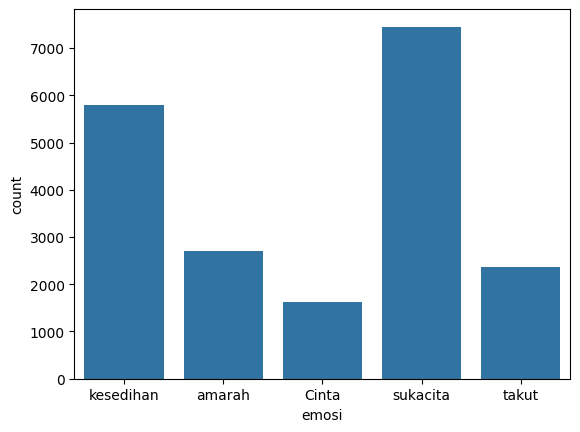

In [ ]:
sns.countplot(x='emosi',data=df);

jumlah_per_status = df["emosi"].value_counts()
print(jumlah_per_status)

### Data Cleaning

In [ ]:
# Data cleaning
print("\nJumlah data duplikat:")
print(df.duplicated().sum())

print("\nJumlah Missing Value per Kolom:")
print(df.isnull().sum())


Jumlah data duplikat:
97

Jumlah Missing Value per Kolom:
teks     0
emosi    0
label    0
dtype: int64


In [ ]:
df.loc[:, 'label'] = df['label'].fillna(df['label'].mode()[0])
df.drop_duplicates(inplace=True)

In [ ]:
print(f"Jumlah data duplikat: {df.duplicated().sum()}")
print(f"jumlah missing values: {df.isnull().sum().sum()}")

Jumlah data duplikat: 0
jumlah missing values: 0


### Data Preprocessing

In [ ]:
# Data preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing
df['teks'] = df['teks'].apply(preprocess_text)

In [ ]:
# Data exploration
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 19851 entries, 0 to 19947
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    19851 non-null  object
 1   emosi   19851 non-null  object
 2   label   19851 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 620.3+ KB


,teks,emosi,label
0,dipermalukan,kesedihan,2
1,beralih perasaan putus asa penuh harapan pedul...,kesedihan,2
2,meraih menit memposting salah,amarah,1
3,nostalgia perapian properti,Cinta,0
4,grouchy,amarah,1


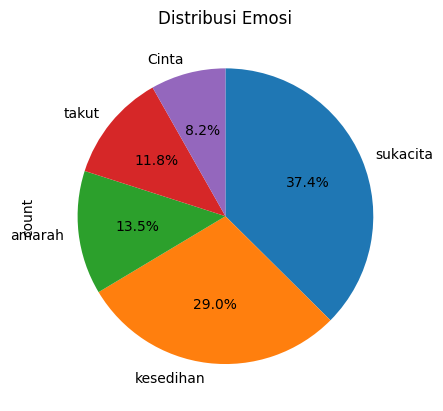

In [ ]:
# Visualization
df['emosi'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Distribusi Emosi')
plt.show()

emosi
sukacita     7430
kesedihan    5754
amarah       2687
takut        2352
Cinta        1628
Name: count, dtype: int64


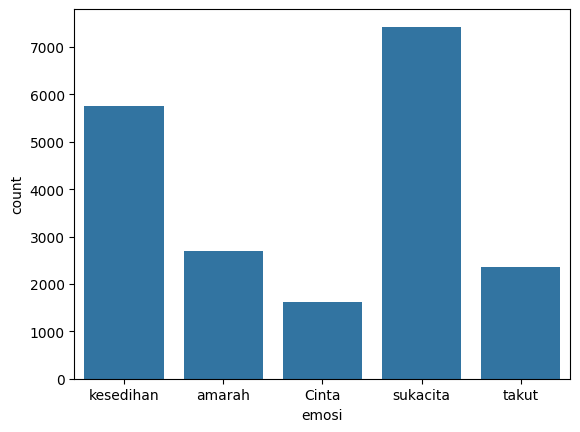

In [ ]:
sns.countplot(x='emosi',data=df);

jumlah_per_status = df["emosi"].value_counts()

print(jumlah_per_status)

### Label Encode & Split Data

In [ ]:
# Prepare data for model training
X = df['teks']
y = df['label']

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

### Tokenization

In [ ]:
import json

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
with open('tokenizer.json', 'w') as f:
    json.dump(word_index, f)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

### Modelling

In [ ]:
# Padding sequences
max_length = 100  # Maximum length of sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Build CNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))  # Output layer

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.3758 - loss: 1.4453 - val_accuracy: 0.5148 - val_loss: 1.1932
Epoch 2/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.5932 - loss: 1.0356 - val_accuracy: 0.6946 - val_loss: 0.8244
Epoch 3/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.7563 - loss: 0.6505 - val_accuracy: 0.7317 - val_loss: 0.8025
Epoch 4/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8372 - loss: 0.4685 - val_accuracy: 0.7324 - val_loss: 0.8763
Epoch 5/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - accuracy: 0.8860 - loss: 0.3410 - val_accuracy: 0.7223 - val_loss: 0.9488


### Evaluasi

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1358 - loss: 1.6124
Test Accuracy: 0.14


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
              precision    recall  f1-score   support

       Cinta      0.000     0.000     0.000       326
      amarah      0.135     1.000     0.239       538
   kesedihan      0.000     0.000     0.000      1151
    sukacita      0.000     0.000     0.000      1486
       takut      0.000     0.000     0.000       470

    accuracy                          0.135      3971
   macro avg      0.027     0.200     0.048      3971
weighted avg      0.018     0.135     0.032      3971


Verification:
Sample y_test: [2 3 2 3 2 2 4 4 4 2]
Sample y_pred: [1 1 1 1 1 1 1 1 1 1]
Label mapping: {0: 'Cinta', 1: 'amarah', 2: 'kesedihan', 3: 'sukacita', 4: 'takut'}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


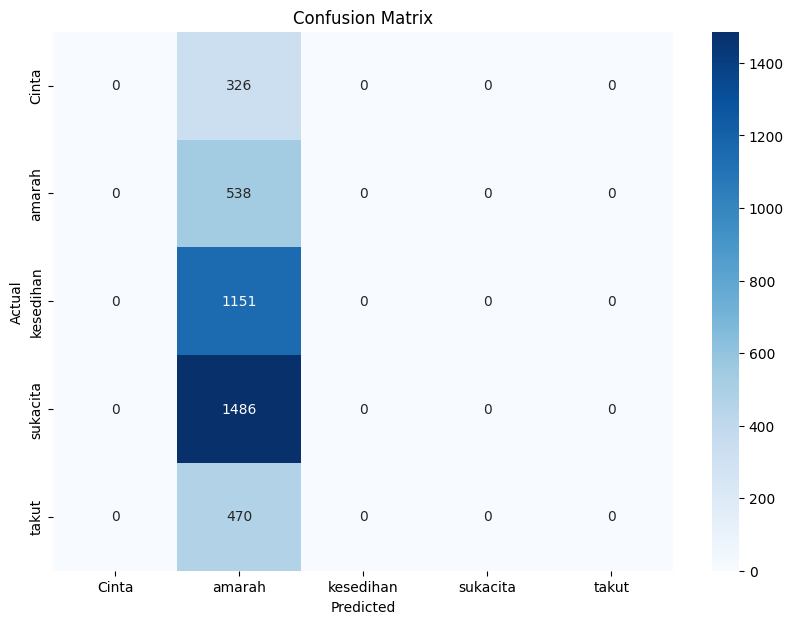

In [ ]:
# Make predictions on the test data
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_pad)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now you can generate the classification report
y_test = np.array(y_test).flatten()
y_pred_classes = y_pred_classes.flatten()

# Define label mapping (adjust according to your dataset)
label_mapping = {
    0: "Cinta",
    1: "amarah",
    2: "kesedihan",
    3: "sukacita",
    4: "takut"
}

# Get existing classes
existing_classes = np.unique(np.concatenate([y_test, y_pred_classes]))
target_names = [label_mapping[i] for i in existing_classes]

# Generate classification report
print(classification_report(
    y_test,
    y_pred_classes,
    target_names=target_names,
    digits=3
))

# Verification
print("\nVerification:")
print("Sample y_test:", y_test[:10])
print("Sample y_pred:", y_pred_classes[:10])
print("Label mapping:", label_mapping)

# You might also want to plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Contoh teks untuk prediksi
test_texts = [
    "Aku sangat kesal dengan pelayanan yang sangat buruk ini!",
    "Aku gemetaran ketakutan saat mendengar suara itu...",
    "Alhamdulillah, akhirnya lulus dengan nilai sempurna!",
    "Hatiku hancur ketika mengetahui kabar duka itu...",
    "Aku tuh seneng banget tau hari ini",
    "Sebenarnya aku sangat bahagia bisa bertemu denganmu setelah sekian lama, tapi di sisi lain aku juga sedih karena besok harus berpisah lagi"
]

# Preprocessing teks
test_seq = tokenizer.texts_to_sequences(test_texts)
test_pad = pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')

# Prediksi
predictions = model.predict(test_pad)
predicted_classes = np.argmax(predictions, axis=1)

# Mapping hasil prediksi ke label emosi
for text, pred in zip(test_texts, predicted_classes):
    print(f"Teks: '{text}'")
    print(f"Prediksi Emosi: {label_mapping[pred]}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Teks: 'Aku sangat kesal dengan pelayanan yang sangat buruk ini!'
Prediksi Emosi: amarah

Teks: 'Aku gemetaran ketakutan saat mendengar suara itu...'
Prediksi Emosi: takut

Teks: 'Alhamdulillah, akhirnya lulus dengan nilai sempurna!'
Prediksi Emosi: sukacita

Teks: 'Hatiku hancur ketika mengetahui kabar duka itu...'
Prediksi Emosi: kesedihan

Teks: 'Aku tuh seneng banget tau hari ini'
Prediksi Emosi: sukacita

Teks: 'Sebenarnya aku sangat bahagia bisa bertemu denganmu setelah sekian lama, tapi di sisi lain aku juga sedih karena besok harus berpisah lagi'
Prediksi Emosi: kesedihan



# Simpan Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive')

ValueError: Mountpoint must be in a directory that exists

In [ ]:
import tensorflow as tf
import os

# Direktori simpan model
os.makedirs("/content/drive/MyDrive/Simpan_Model",exist_ok=True)

# Simpan Format SavedModel (Standard TensorFlow)
saved_model_dir = "/content/drive/MyDrive/Simpan_Model/saved_model"
model.export(saved_model_dir)
print("Model disimpan dalam format SavedModel di:", saved_model_dir)

Saved artifact at '/content/drive/MyDrive/Simpan_Model/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138010050434000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050437264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050438032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050433232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050438992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050438800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050439760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050440336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050441296: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model disimpan dalam format SavedModel di: /content/drive/MyDri

In [ ]:
# Simpan Format TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
tflite_path = "/content/drive/MyDrive/Simpan_Model/model.tflite"

with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print("Model disimpan dalam format TensorFlow Lite di:", tflite_path)

Model disimpan dalam format TensorFlow Lite di: /content/drive/MyDrive/Simpan_Model/model.tflite


In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  "/content/drive/MyDrive/Simpan_Model/saved_model" \
  "/content/drive/MyDrive/Simpan_Model/tfjs_model"

2025-06-07 12:11:09.205272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749298269.253920    7481 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749298269.265696    7481 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-07 12:11:16.453524: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1749298276.622204    7481 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [ ]:
import os
import subprocess

save_dir = '/content/drive/MyDrive/Simpan_Model/saved_model'
tfjs_dir = '/content/drive/MyDrive/Simpan_Model/tfjs_model'

os.makedirs(tfjs_dir, exist_ok=True)
command = [
    'tensorflowjs_converter',
    '--input_format=tf_saved_model',
    '--output_format=tfjs_graph_model',
    save_dir,
    tfjs_dir
]

result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

if result.returncode == 0:
    print(f"Model berhasil dikonversi ke TensorFlow.js di: {tfjs_dir}")
else:
    print("Gagal mengonversi model ke TensorFlow.js")
    print("Error message:\n", result.stderr)

Model berhasil dikonversi ke TensorFlow.js di: /content/drive/MyDrive/Simpan_Model/tfjs_model


In [ ]:
# Simpan Format TensorFlow.js
import subprocess

tfjs_target_dir = "/content/drive/MyDrive/Simpan_Model/tfjs_model"
subprocess.run([
    "tensorflowjs_converter",
    "--input_format", "tf_saved_model",
    "--output_format", "tfjs_graph_model",
    "--signature_name", "serving_default",
    "--saved_model_tags", "serve",
    saved_model_dir,
    tfjs_target_dir
])
print("Model disimpan dalam format TensorFlow.js di:", tfjs_target_dir)

Model disimpan dalam format TensorFlow.js di: /content/drive/MyDrive/Simpan_Model/tfjs_model


In [ ]:
import os

saved_model_path = '/content/drive/MyDrive/Simpan_Model/saved_model_tfjs'
os.makedirs(saved_model_path, exist_ok=True)

# Gunakan export() jika model dari TFDF, atau save() jika model Keras biasa
model.export(saved_model_path)  # untuk model Sequential atau Functional Keras
print(f"Model disimpan ke: {saved_model_path}")

Saved artifact at '/content/drive/MyDrive/Simpan_Model/saved_model_tfjs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138010050434000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050437264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050438032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050433232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050438992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050438800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050439760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050440336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138010050441296: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model disimpan ke: /content/drive/MyDrive/Simpan_Model/sav

In [ ]:
!pip install tensorflowjs

# Bagian Baru

In [ ]:
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  "/content/drive/MyDrive/Simpan_Model/saved_model_tfjs" \
  "/content/drive/MyDrive/Simpan_Model/model_tfjs"

2025-06-07 12:17:06.782340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749298626.845201    9003 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749298626.862431    9003 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-07 12:17:15.898794: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1749298636.129619    9003 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [ ]:
!ls /content/drive/MyDrive/Simpan_Model/

model_tfjs  model.tflite  saved_model  saved_model_tfjs  tfjs_model


In [ ]:
!ls /content/drive/MyDrive/Simpan_Model/saved_model_tfjs/

assets	fingerprint.pb	saved_model.pb	variables


In [ ]:
!ls /content/drive/MyDrive/Simpan_Model/model_tfjs/

group1-shard1of1.bin  model.json


In [ ]:
!ls -la /content/

total 16
drwxr-xr-x 1 root root 4096 Jun  9 13:37 .
drwxr-xr-x 1 root root 4096 Jun 10 20:37 ..
drwxr-xr-x 4 root root 4096 Jun  9 13:36 .config
drwxr-xr-x 1 root root 4096 Jun  9 13:37 sample_data


In [ ]:
!find /content/drive/MyDrive/ -name "tokenizer.json"

find: ‘/content/drive/MyDrive/’: No such file or directory
